# Time Series Methods Demo

In [1]:
from __future__ import annotations
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from SpatialScan.preprocessing import *
from SpatialScan.synthetic import *
from SpatialScan.timeseriesjam import *
import time

In [2]:
df = pd.read_csv('jamcam2.csv', index_col=False, parse_dates=[4, 5])

In [3]:
df["n_vehicles_in_interval"]=df["n_vehicles_in_interval"].astype(float)

In [4]:
DF=jam_preprocessor(df, max_anom = 5, N_sigma = 3, repeats = 2, percentage_missing=15)

Using the 16-day rolling median to remove outliers ...
Using 2 iterations to remove points outside of 3 sigma from the rolling median ...
Calculating threshold(s): Iteration 2 of 2...
Threshold(s) calculated.

Dropping detectors with more than 5 anomalies...
Dropping detectors with sufficiently high amounts of missing data (>15%)...
1 detectors dropped: {1.07313}



1.06692


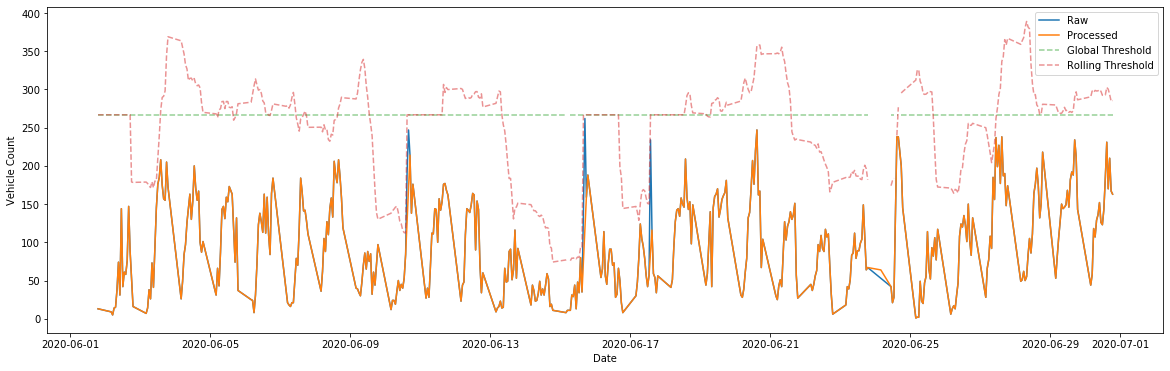

In [5]:
plot_processing(df, DF)

In [6]:
detectors=DF["detector_id"].unique()

## Holt-Winters
The multiplicative Holt–Winters’ (HW) method is a more dynamic forecasting method that takes into account smaller periodic trends, as well as long term trends (such as seasonal trends). It has three main components: the smoothed value $S_t$ , trend component $Tt$ , and the periodic component $I_t$

### $
S_{t}=\alpha \frac{c_{i}^{t}}{I_{t+16}}+(1-\alpha)\left(S_{t+1}+T_{t+1}\right) \\
T_{t}=\beta\left(S_{t}-S_{t+1}\right)+(1-\beta) T_{t+1} \\
I_{t}=\gamma \frac{c_{i}^{t}}{S_{t}}+(1-\gamma) I_{t+16}$

These are iterated through historical data, and then extended to the forecasting period, where the baseline estimate for the next hour is then given by $b^t_i=\left(S_{t+1}+T_{t+1}\right) I_{t+24}$. the baseline is then replaced for count in the equations above, and iterated across the forecasting period.

Strengths: Very quick, simple

Weaknesses: Over simplistic, does not give uncertainty estimates, does not extend well to longer forecasts

In [69]:
CB_HW=count_baselineJ(DF, 20, 3, alpha = 0.02, beta = 0.02, gamma = 0.4)

Input dataframe contains data spanning 2020-06-01 18:00:00 to 2020-06-30 19:00:00.
Using data from 2020-06-01 18:00:00 to 2020-06-27 19:00:00, to forecast counts between 2020-06-27 19:00:00 and 2020-06-30 19:00:00 for 22 detectors using HW method...
Forecasting complete.


1.07325


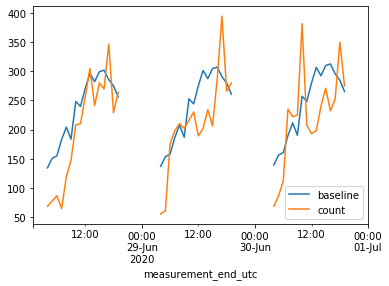

In [70]:
forecast_plotJ(CB_HW)

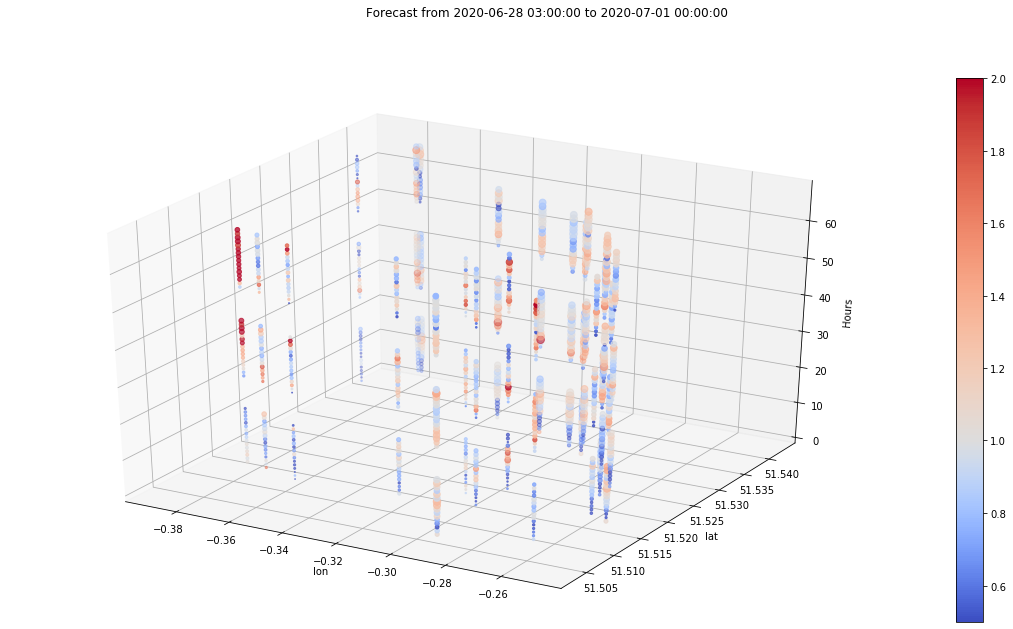

In [71]:
CB_plot(CB_HW)

## Gaussian Process
for the sake of our GP modelling we shall consider two kernels: the standard squared exponential kernel $k_{\mathrm{SE}}$ and the periodic kernel $k_{\mathrm{P}}$, given below.
        
#### $
k_{\mathrm{SE}}\left(\boldsymbol{x}, \boldsymbol{x}^{\prime}\right)=\alpha^{2} \exp \left(-\frac{1}{2} \frac{\left(x_{d}-x_{d}^{\prime}\right)^{2}}{l}\right)$

#### $
k_{\mathrm{P}}\left(\boldsymbol{x}, \boldsymbol{x}^{\prime}\right)=\alpha^{2} \exp \left(-\frac{1}{2}\left(\frac{\sin \left(\tau\left(x_{d}-x_{d}^{\prime}\right)\right)}{l}\right)^{2}\right) 
$

for the periodic elements likely from traffic forecasts, we need the periodic kernel. Considering the patterns associated with traffic forecast, we suggest a tailored kernel composed of the sum of three kernels:

$k_1(x, x^\prime)$ a periodic kernel with a periodicity hyper-parameter equal to 16 hours to capture the daily periodic patterns 
    
$k_2(x, x^\prime)$ a periodic kernel with a periodicity hyper-parameter equal to 16 $\times$ 7 hours to capture the day-of-the-week periodicity
    
$k_3(x, x^\prime)$ a squared exponential kernel for deviations and underlying trends

Our tailored kernel will be using a combination of these three, $k(x, x^\prime) = k_1(x, x^\prime) \times k_2(x, x^\prime) + k_3(x, x^\prime)$, thus leaving six hyper-parameters to fine tune, three variances and three length scales. These are optimised using GPflows optimisation module

In [60]:
CB_GP=count_baselineJ(DF, 20, 3, method="GP")

Input dataframe contains data spanning 2020-06-01 18:00:00 to 2020-06-30 19:00:00.
Using data from 2020-06-01 18:00:00 to 2020-06-27 19:00:00, to forecast counts between 2020-06-27 19:00:00 and 2020-06-30 19:00:00 for 22 detectors using GP method...
Forecasting complete.


1.0668799999999998


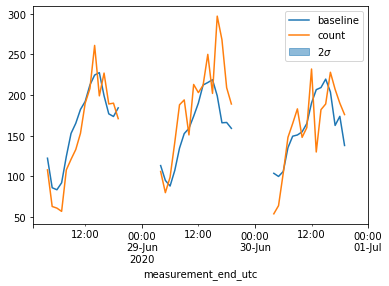

In [61]:
forecast_plotJ(CB_GP)

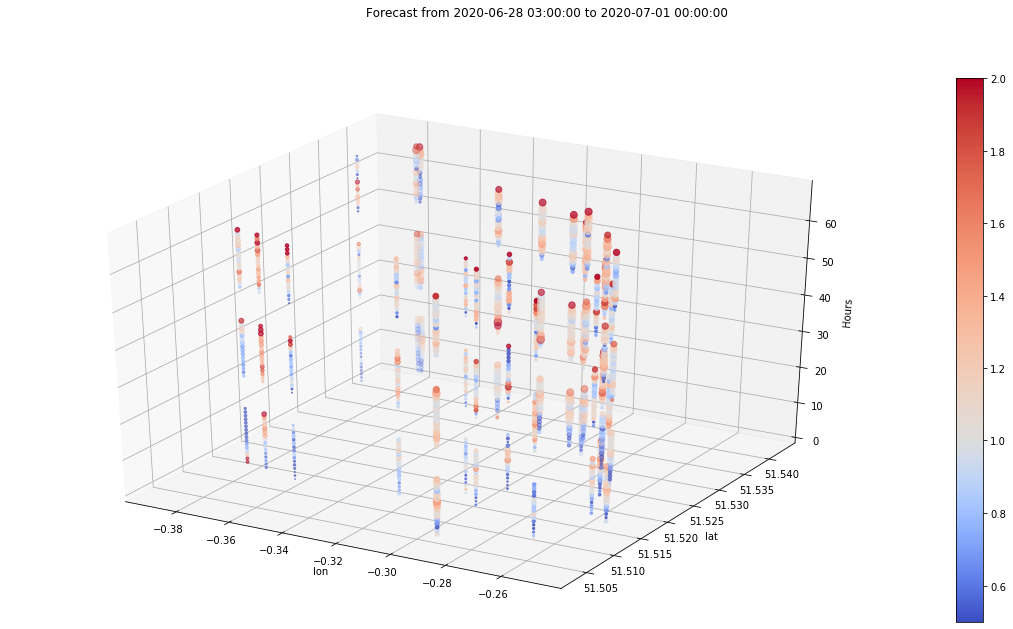

In [62]:
CB_plot(CB_GP)